# TASK 1

We implemented both the bootstrap filter and the exact filter described in the paper, comparing their performance on simulated data where the true parameter values are known. Following the approach illustrated in Figure 1, this comparison focuses primarily on likelihood profiles. We also analyzed the behavior of each filter individually. Furthermore, to ensure a faithful reproduction, we simulated data that closely mimics the parameters used in the paper, establishing a consistent baseline for each step of the analysis.

## <u>Imports</u>

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
project_root = Path.cwd().parent

In [2]:
# Standard Library
import time

#  Third-Party Libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import gammaln
from scipy.stats import poisson, nbinom
from tqdm import tqdm, trange

# Particles Package
import particles
import particles.state_space_models as ssm
import particles.distributions as dists

# Local Project Modules 
# Source Code (src)
import src.cox_simulation as cx
import src.creal_filter as cf
from src.particle_filter import BootstrapPF
from src.particles_library import CrealCoxSSM, pf_loglik_particles_xbeta

# Utilities (utils)
import utils.load_data as ld
import utils.plots as pl
import utils.comparaison as comp

## <u>Data simulation</u>

We simulate count time series data designed to mimic the structure studied in Creal (2017), while keeping full control over the true parameter values.

Let $ y_t $ denote the observed count at time $ t = 1, \dots, T $.
Conditionally on a time-varying intensity, observations are generated from a Poisson distribution:
$
y_t \sim \text{Poisson}(\lambda_t).
$

The intensity $\lambda_t $ is constructed to depend on observed covariates through an exponential link:
$
\lambda_t = \tau_t \exp(X_t^\top \beta),
$
where:
- $ X_t $ is a vector of covariates (including an intercept),
- $ \beta $ is a vector of regression coefficients,
- $ \tau_t $ is an optional exposure or offset term (set to 1 in most experiments).

We consider three types of simulated datasets:
1. A baseline series with no covariates (intercept only),
2. A series with one additional Gaussian covariate,
3. A series with two covariates: one Gaussian white noise and one autoregressive AR(1) process.

All covariates are generated independently of the observation noise.  
The true parameter values are fixed and known, allowing us to assess the performance of filtering and likelihood-based methods under controlled conditions.

In [3]:
# Simulation without covariates

TRUE_PARAMS = {"phi": 0.965, "nu": 2.5, "c": 0.2}
T = 400
seed = 1
sim = cx.CoxProcessSimulation(T=T, **TRUE_PARAMS, seed=seed)
# y_t | h_t ~ Poisson(h_t)
y0, h0, z0 = sim.simulate()

In [4]:
# One additional Gaussian covariate

TRUE_PARAMS = {"phi": 0.8, "nu": 2.5, "c": 0.2}
T = 400
seed = 1

rng = np.random.default_rng(seed)

# covariables: intercept + variable
X = np.column_stack([
    np.ones(T),
    rng.normal(size=T)
])

beta = np.array([-0.5, 0.3])   # coefficients for x 
tau = np.ones(T)               # exposition (optional; tau=1)

sim = cx.CoxProcessSimulation(T=T, **TRUE_PARAMS, seed=seed)
y1, h1, z1, expo1 = sim.simulate(X=X, beta=beta, tau=tau, return_exposure=True)


In [3]:
TRUE_PARAMS = {"phi": 0.8, "nu": 2.5, "c": 0.2}
T = 1000
seed = 1

rng2 = np.random.default_rng(seed)

x1 = rng2.normal(size=T)

x2 = np.zeros(T)
for t in range(1, T):
    x2[t] = 0.8 * x2[t - 1] + rng2.normal()

X2 = np.column_stack([np.ones(T), x1, x2])
beta2 = np.array([-0.5, 0.4, -0.3])
tau2 = np.ones(T)

sim2 = cx.CoxProcessSimulation(T=T, **TRUE_PARAMS, seed=seed + 1)
y2, h2, z2, expo2 = sim2.simulate(X=X2, beta=beta2, tau=tau2, return_exposure=True)

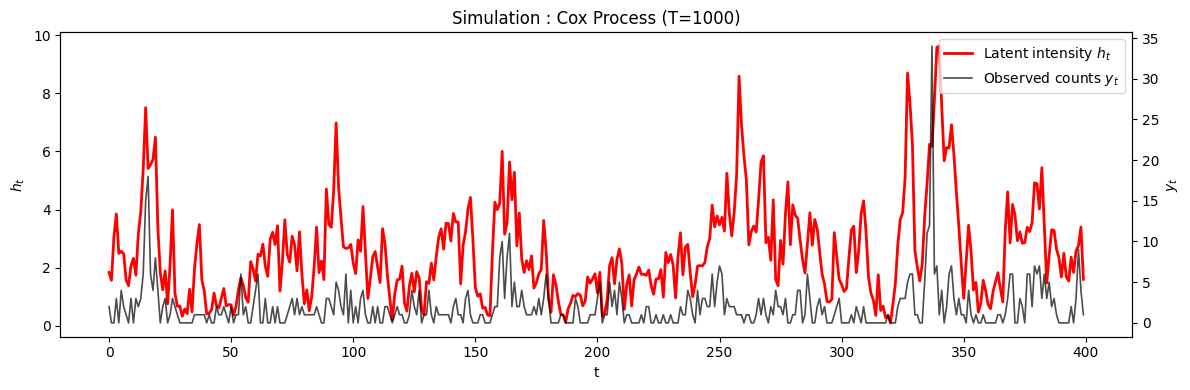

In [6]:
# pl.plot_time_series(y, h, T_show=1000, start=0, use_bars=False)
# pl.plot_histogram_h(h, nu=TRUE_PARAMS["nu"], phi=TRUE_PARAMS["phi"], c=TRUE_PARAMS["c"], burn=200)
# pl.plot_acf_h(h, lags=40, burn=200)
# pl.plot_acf_y(y, lags=40, burn=200)
# pl.plot_overlay_clean(y0, h0, T_show=400, start=0)
#  pl.plot_overlay_clean(y1, h1, T_show=400, start=0)
pl.plot_overlay_clean(y2, h2, T_show=400, start=0)

## <u>Exact filter (Creal) </u>

Exact likelihood over phi: 100%|██████████| 500/500 [13:02<00:00,  1.57s/it]


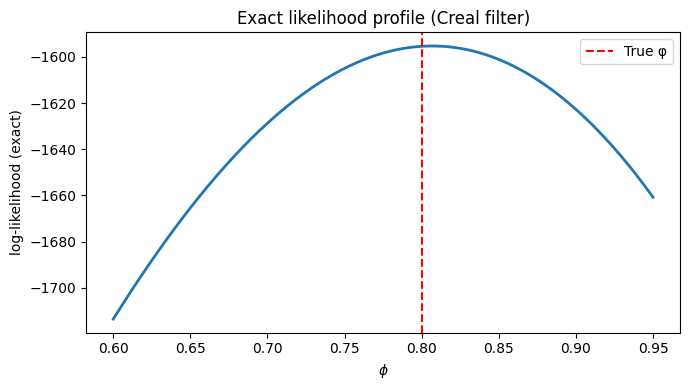

In [ ]:
# Test exact filter on serie 2 on phi

phi_grid = np.linspace(0.6, 0.95, 500)
ll_exact = []

f = cf.ExactFilter(y2, Z_trunc=300)

for phi in tqdm(phi_grid, desc="Exact likelihood over phi"):
    ll = f.log_likelihood(
        phi=phi,
        nu=TRUE_PARAMS["nu"],
        c=TRUE_PARAMS["c"],
        exposure=expo2
    )
    ll_exact.append(ll)

ll_exact = np.array(ll_exact)

plt.figure(figsize=(7,4))
plt.plot(phi_grid, ll_exact, lw=2)
plt.axvline(TRUE_PARAMS["phi"], color="red", ls="--", label="True φ")
plt.xlabel(r"$\phi$")
plt.ylabel("log-likelihood (exact)")
plt.title("Exact likelihood profile (Creal filter)")
plt.legend()
plt.tight_layout()
plt.show()

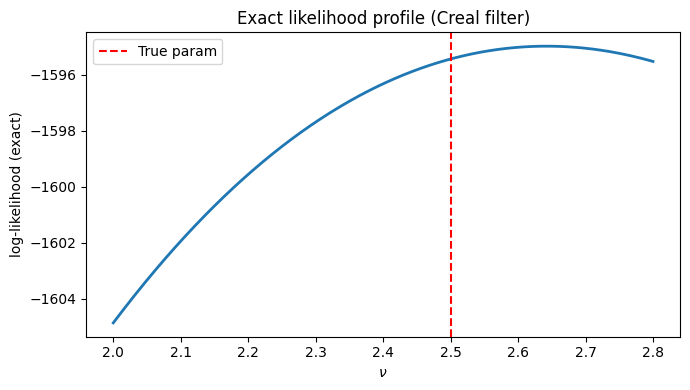

In [ ]:
# Test exact filter on serie 2 on nu

nu_grid = np.linspace(2.0, 2.8, 500) #2.5
ll_exact_nu = []

for nu in tqdm(nu_grid, desc="Exact likelihood over nu"):
    ll = f.log_likelihood(
        phi=TRUE_PARAMS["phi"],
        nu=nu,
        c=TRUE_PARAMS["c"],
        exposure=expo2
    )
    ll_exact_nu.append(ll)

ll_exact_nu = np.array(ll_exact_nu)

plt.figure(figsize=(7,4))
plt.plot(nu_grid, ll_exact_nu, lw=2)
plt.axvline(TRUE_PARAMS["nu"], color="red", ls="--", label="True param")
plt.xlabel(r"$\nu$")
plt.ylabel("log-likelihood (exact)")
plt.title("Exact likelihood profile (Creal filter)")
plt.legend()
plt.tight_layout()
plt.show()

Stability over Z: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


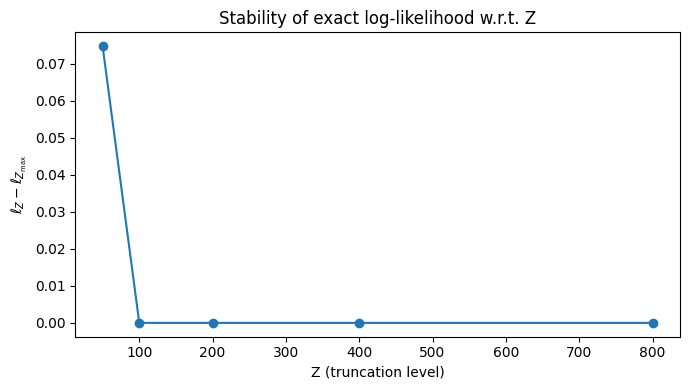

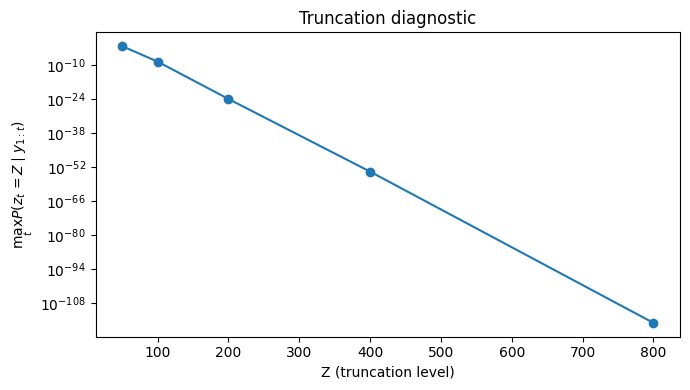

In [ ]:
# Impact of Z truncature

Z_list = [50, 100, 200, 400, 800]
ll_Z = []
max_pZ_list = []

for Z in tqdm(Z_list, desc="Stability over Z"):
    fZ = cf.ExactFilter(y2, Z_trunc=Z)
    ll, max_pZ = fZ.log_likelihood(
        phi=TRUE_PARAMS["phi"],
        nu=TRUE_PARAMS["nu"],
        c=TRUE_PARAMS["c"],
        exposure=expo2,
        return_diag=True
    )
    ll_Z.append(ll)
    max_pZ_list.append(max_pZ)

ll_Z = np.array(ll_Z)
max_pZ_list = np.array(max_pZ_list)

plt.figure(figsize=(7,4))
plt.plot(Z_list, ll_Z - ll_Z[-1], marker="o")
plt.xlabel("Z (truncation level)")
plt.ylabel(r"$\ell_Z - \ell_{Z_{\max}}$")
plt.title("Stability of exact log-likelihood w.r.t. Z")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.semilogy(Z_list, max_pZ_list, marker="o")
plt.xlabel("Z (truncation level)")
plt.ylabel(r"$\max_t P(z_t = Z \mid y_{1:t})$")
plt.title("Truncation diagnostic")
plt.tight_layout()
plt.show()

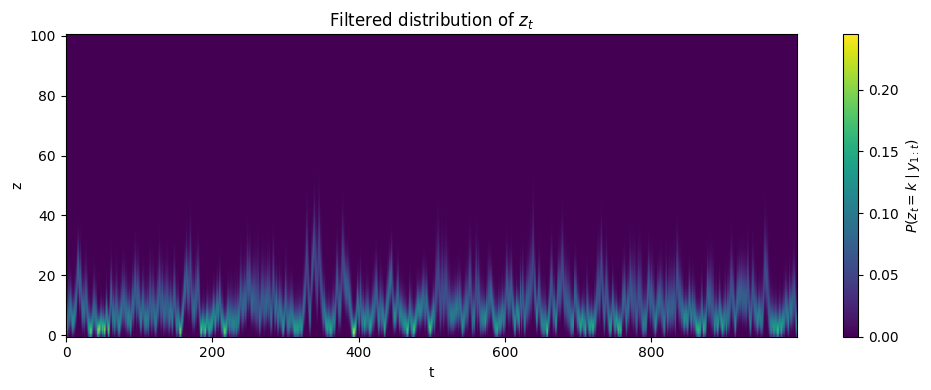

In [9]:
# Heatmap Distribution filtrée

Z = 100
f = cf.ExactFilter(y2, Z_trunc=Z)

ll, filt_prob = f.log_likelihood(
    phi=TRUE_PARAMS["phi"],
    nu=TRUE_PARAMS["nu"],
    c=TRUE_PARAMS["c"],
    exposure=expo2,
    return_filter=True
)

plt.figure(figsize=(10,4))
plt.imshow(
    filt_prob.T,
    aspect="auto",
    origin="lower",
    cmap="viridis"
)
plt.colorbar(label=r"$P(z_t=k \mid y_{1:t})$")
plt.xlabel("t")
plt.ylabel("z")
plt.title("Filtered distribution of $z_t$")
plt.tight_layout()
plt.show()

The filtered distribution of the auxiliary variable z_t remains concentrated well below the truncation level Z=100, which confirms that truncation error is negligible.

Quantiles of z_t: 100%|██████████| 1000/1000 [00:00<00:00, 81585.37it/s]


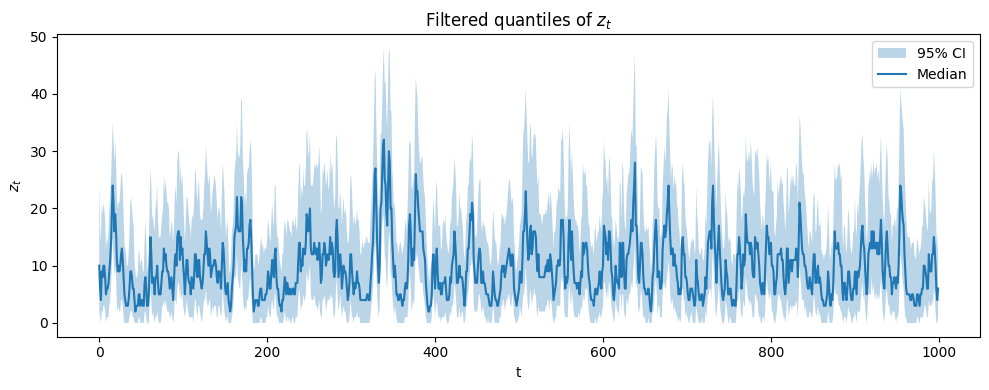

In [ ]:
# Filtered quantiles of zt

z_grid = np.arange(filt_prob.shape[1])

q_low = np.zeros(filt_prob.shape[0])
q_med = np.zeros(filt_prob.shape[0])
q_high = np.zeros(filt_prob.shape[0])

for t in tqdm(range(filt_prob.shape[0]), desc="Quantiles of z_t"):
    cdf = np.cumsum(filt_prob[t])
    q_low[t] = z_grid[np.searchsorted(cdf, 0.025)]
    q_med[t] = z_grid[np.searchsorted(cdf, 0.50)]
    q_high[t] = z_grid[np.searchsorted(cdf, 0.975)]

plt.figure(figsize=(10,4))
plt.fill_between(range(len(q_med)), q_low, q_high, alpha=0.3, label="95% CI")
plt.plot(q_med, lw=1.5, label="Median")
plt.xlabel("t")
plt.ylabel(r"$z_t$")
plt.title("Filtered quantiles of $z_t$")
plt.legend()
plt.tight_layout()
plt.show()

Filtered mean of h_t: 100%|██████████| 1000/1000 [00:00<00:00, 90252.49it/s]


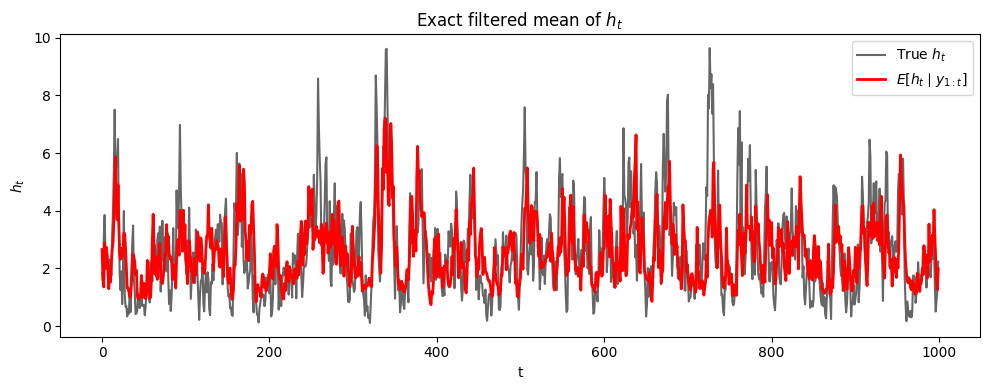

In [ ]:
# Exact filtered mean of E[h_t ! y_{1:t}] vs true ht

Eh = np.zeros(T)
z_grid = np.arange(filt_prob.shape[1])

for t in tqdm(range(T), desc="Filtered mean of h_t"):
    scale_post = TRUE_PARAMS["c"] / (1.0 + TRUE_PARAMS["c"] * expo2[t])
    shape_post = TRUE_PARAMS["nu"] + y2[t] + z_grid
    Eh[t] = np.sum(filt_prob[t] * (shape_post * scale_post))

plt.figure(figsize=(10,4))
plt.plot(h2, color="black", alpha=0.6, label="True $h_t$")
plt.plot(Eh, color="red", lw=2, label=r"$E[h_t \mid y_{1:t}]$")
plt.xlabel("t")
plt.ylabel(r"$h_t$")
plt.title("Exact filtered mean of $h_t$")
plt.legend()
plt.tight_layout()
plt.show()

## <u> Particle filter </u>

PF cloud over phi: 100%|██████████| 80/80 [01:51<00:00,  1.40s/it]


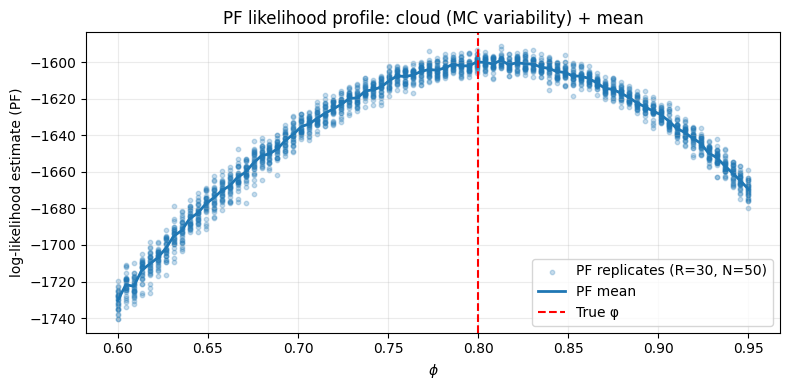

In [ ]:
# data
y = np.asarray(y2, dtype=np.int64)
expo = np.asarray(expo2, dtype=float)

nu = TRUE_PARAMS["nu"]
c  = TRUE_PARAMS["c"]
phi_true = TRUE_PARAMS["phi"]

#  nuage 
phi_grid = np.linspace(0.6, 0.95, 80)
R = 30     # nb of replications 
N = 50   # nb particules

ll_pf_mat = np.zeros((len(phi_grid), R))

for i, phi in enumerate(tqdm(phi_grid, desc="PF cloud over phi")):
    for r in range(R):
        ll_pf_mat[i, r] = pf_loglik_particles_xbeta(
                    y=y, X=X2, beta=beta2, tau=np.ones(len(y)),
                    nu=nu, phi=phi, c=c,
                    N=N, seed=10_000_000 + 1000*N + 10*i + r
                )

# plot nuage + mean 
plt.figure(figsize=(8,4))
plt.scatter(np.repeat(phi_grid, R), ll_pf_mat.reshape(-1),
            s=10, alpha=0.25, label=f"PF replicates (R={R}, N={N})")
plt.plot(phi_grid, ll_pf_mat.mean(axis=1), lw=2, label="PF mean")

plt.axvline(phi_true, color="red", ls="--", lw=1.5, label="True φ")
plt.xlabel(r"$\phi$")
plt.ylabel("log-likelihood estimate (PF)")
plt.title("PF likelihood profile: cloud (MC variability) + mean")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

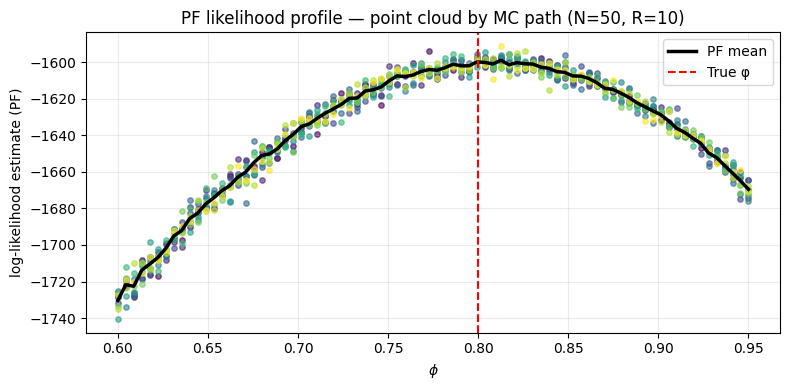

In [18]:
plt.figure(figsize=(8,4))

R=10
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, R))

for r in range(R):
    plt.scatter(
        phi_grid,
        ll_pf_mat[:, r],
        color=colors[r],
        s=15,
        alpha=0.6
    )

# mean PF
plt.plot(phi_grid, ll_pf_mat.mean(axis=1),
         color="black", lw=2.5, label="PF mean")

# true phi
plt.axvline(phi_true, color="red", ls="--", lw=1.5, label="True φ")

plt.xlabel(r"$\phi$")
plt.ylabel("log-likelihood estimate (PF)")
plt.title(f"PF likelihood profile — point cloud by MC path (N={N}, R={R})")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_35928/3957894251.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([phi_hat], labels=[f"N={N}"], showfliers=True)
/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_35928/3957894251.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


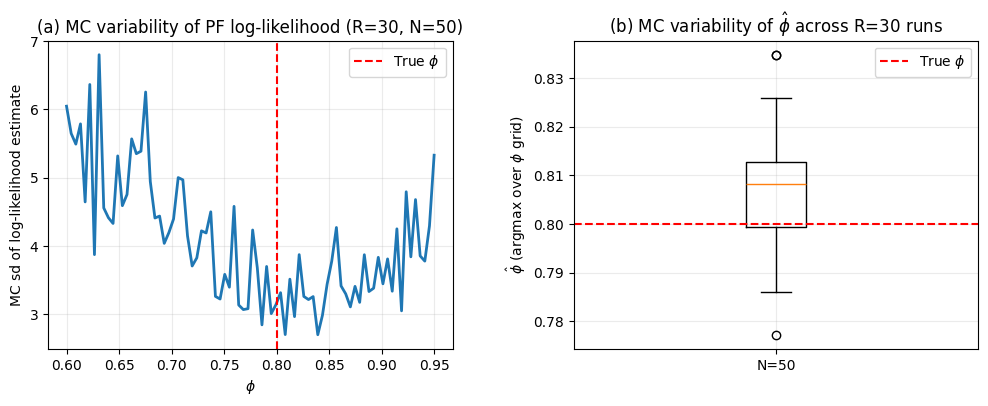

In [15]:
phi_grid = np.asarray(phi_grid, dtype=float)
ll_pf_mat = np.asarray(ll_pf_mat, dtype=float)
G, R = ll_pf_mat.shape

# (a) Monte Carlo standard deviation of the PF log-likelihood
sd_pf = ll_pf_mat.std(axis=1, ddof=1)

# (b) phi-hat for each Monte Carlo replication
idx_max = np.argmax(ll_pf_mat, axis=0)
phi_hat = phi_grid[idx_max]


fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(12, 4),
    gridspec_kw={"wspace": 0.3}   
)

# Left panel: MC standard deviation vs phi

ax1.plot(phi_grid, sd_pf, lw=2)
ax1.axvline(phi_true, color="red", ls="--", lw=1.5, label=r"True $\phi$")
ax1.set_xlabel(r"$\phi$")
ax1.set_ylabel("MC sd of log-likelihood estimate")
ax1.set_title(rf"(a) MC variability of PF log-likelihood (R={R}, N={N})")
ax1.legend()
ax1.grid(alpha=0.25)


# Right panel: variability of phi-hat across MC runs

ax2.boxplot([phi_hat], labels=[f"N={N}"], showfliers=True)
ax2.axhline(phi_true, color="red", ls="--", lw=1.5, label=r"True $\phi$")
ax2.set_ylabel(r"$\hat\phi$ (argmax over $\phi$ grid)")
ax2.set_title(rf"(b) MC variability of $\hat\phi$ across R={R} runs")
ax2.legend()
ax2.grid(alpha=0.25)

plt.tight_layout()
plt.show()

## <u> Comparaison implemented particles and library based one </u>

In [ ]:
# data
y = np.asarray(y2, dtype=np.int64)
expo = np.asarray(expo2, dtype=float)

nu = TRUE_PARAMS["nu"]
phi = TRUE_PARAMS["phi"]
c  = TRUE_PARAMS["c"]

N = 5000     
R = 20       

ll_hand = np.empty(R)
ll_part = np.empty(R)
t_hand  = np.empty(R)
t_part  = np.empty(R)

for r in trange(R, desc="A/B: hand vs particles"):
    seed = 1000 + r

    # PF hand
    t0 = time.time()
    pf = BootstrapPF(nu=nu, phi=phi, c=c, expo=expo, N=N, seed=seed, resample=True)
    llh, _ = pf.run(y, progress=False)
    t_hand[r] = time.time() - t0
    ll_hand[r] = llh

    # PF library based
    t0 = time.time()
    llp = pf_loglik_particles_xbeta(y=y, nu=nu, phi=phi, c=c, expo=expo, N=N, seed=seed)
    t_part[r] = time.time() - t0
    ll_part[r] = llp

diff = ll_hand - ll_part

=== loglik ===
hand:      mean=-1595.394, sd=0.344
particles:  mean=-1595.430, sd=0.244
diff(h-p):  mean=0.036, sd=0.439
corr: -0.086

=== timing (s) ===
hand:      mean=0.662
particles: mean=0.400


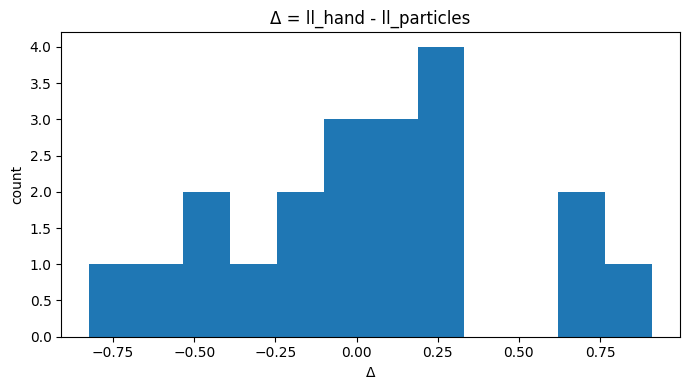

/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_6607/4160243438.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ll_hand, ll_part], labels=["hand", "particles"])


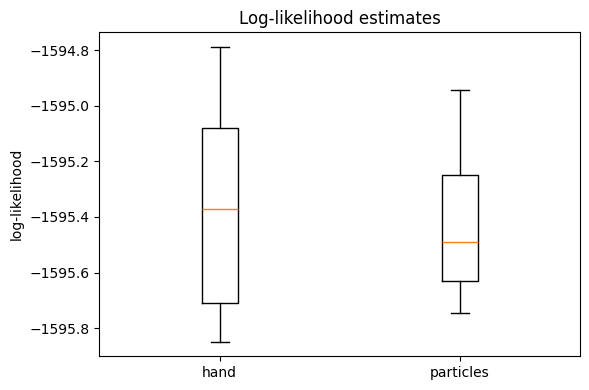

In [ ]:
print("=== loglik ===")
print(f"hand:      mean={ll_hand.mean():.3f}, sd={ll_hand.std(ddof=1):.3f}")
print(f"particles:  mean={ll_part.mean():.3f}, sd={ll_part.std(ddof=1):.3f}")
print(f"diff(h-p):  mean={diff.mean():.3f}, sd={diff.std(ddof=1):.3f}")
print(f"corr: {np.corrcoef(ll_hand, ll_part)[0,1]:.3f}")

print("\n=== timing (s) ===")
print(f"hand:      mean={t_hand.mean():.3f}")
print(f"particles: mean={t_part.mean():.3f}")

# plots
plt.figure(figsize=(7,4))
plt.hist(diff, bins=12)
plt.title("Difference = ll_hand - ll_particles")
plt.xlabel("Difference")
plt.ylabel("count")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
plt.boxplot([ll_hand, ll_part], labels=["hand", "particles"])
plt.title("Log-likelihood estimates")
plt.ylabel("log-likelihood")
plt.tight_layout()
plt.show()

## <u> Comparaison exact filter vs particle filter </u>

For the sake of simplicity, we based this part (and next steps) of the study on simulated data generated using the process described above. This ensures a consistent baseline for the remainder of the project. The data is provided in the `data` section, within the file `data_groupe_T1000.xlsx`.

### Data gather

Loading Series 1...
 Load: Serie_1 (Beta: None)


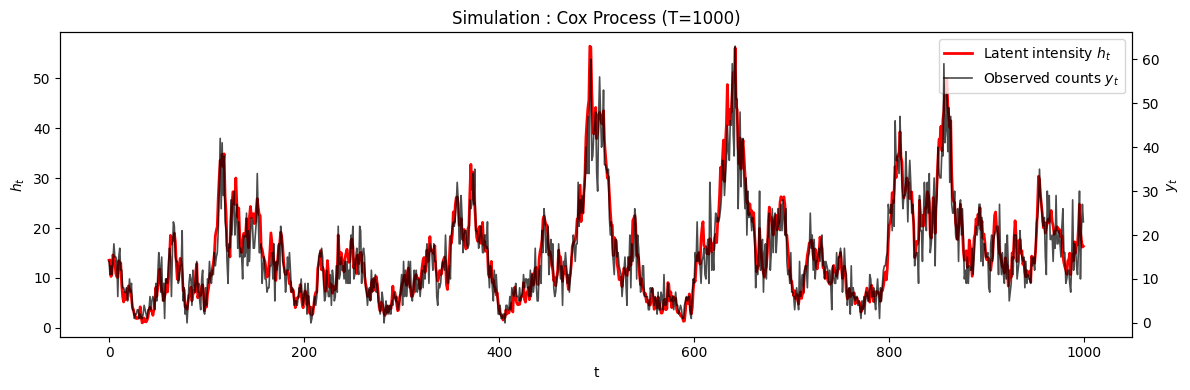

Loading Series 2...
 Load: Serie_2 (Beta: [-0.5  0.3])


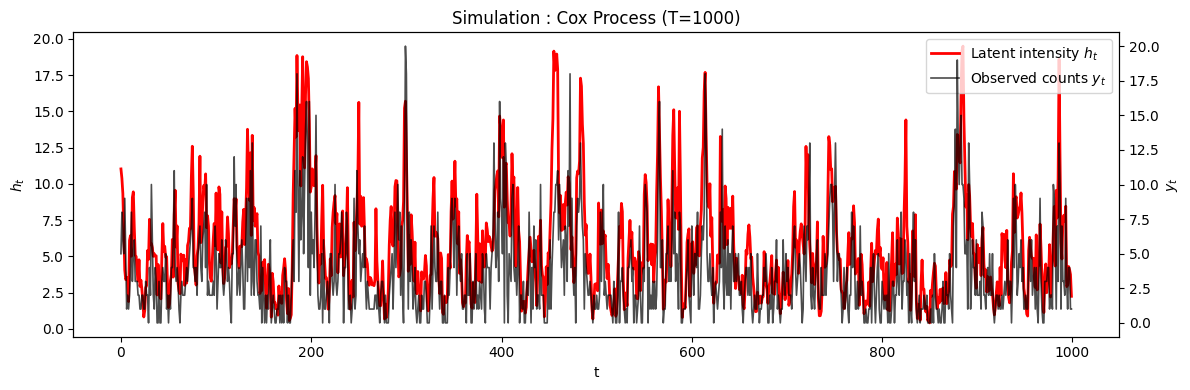

Loading Series 3...
 Load: Serie_3 (Beta: [-0.5  0.4 -0.3])


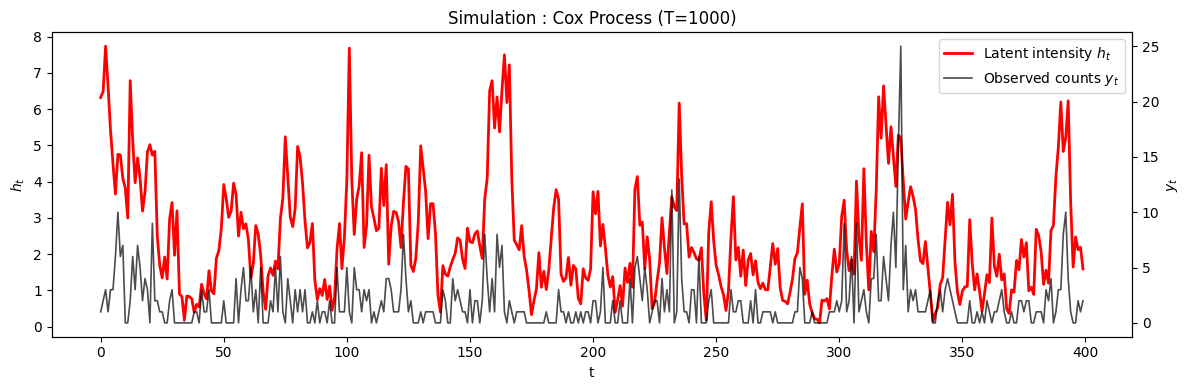

In [3]:
excel_path = project_root / "data" / "data_groupe_T1000.xlsx"
if not excel_path.exists():
    raise FileNotFoundError(f"File not found: {excel_path}")


# === Series 1 (No Covariates) ===
# Params: {"phi": 0.965, "nu": 2.5, "c": 0.2}
print("Loading Series 1...")
y1, X1, h1, beta1, p1 = ld.load_data(excel_path, "Serie_1")
pl.plot_overlay_clean(y1, h1, T_show=len(y1), start=0)


# === Series 2 (With Covariates) ===
# Params: {"phi": 0.8, "nu": 3, "c": 0.4}, beta = [-0.5, 0.3]
print("Loading Series 2...")
y2, X2, h2, beta2, p2 = ld.load_data(excel_path, "Serie_2")
pl.plot_overlay_clean(y2, h2, T_show=len(y2), start=0)


# === Series 3 (With Covariates) ===
# Params: {"phi": 0.8, "nu": 2.5, "c": 0.2}, beta = [-0.5, 0.4, -0.3]
print("Loading Series 3...")
y3, X3, h3, beta3, p3 = ld.load_data(excel_path, "Serie_3")
pl.plot_overlay_clean(y3, h3, T_show=min(len(y3), 400), start=0)

SERIES = [
    ("Serie_1", y1, X1, beta1, p1),
    ("Serie_2", y2, X2, beta2, p2),
    ("Serie_3", y3, X3, beta3, p3),
]

### Exact filter 

#### $ \Phi $ parameter

In [ ]:
rows = []

phi_grid = np.linspace(0.60, 0.999, 200)

for name, y, X, beta, params in SERIES:
    nu = float(params["nu"])
    c  = float(params["c"])
    phi_true = float(params["phi"])

    f = cf.ExactFilter(y, Z_trunc=500)

    for phi in tqdm(phi_grid, desc=f"Exact profile {name}"):
        ll = f.log_likelihood(
            phi=phi,
            nu=nu,
            c=c,
            X=X,
            coeffs=beta,
            tau=np.ones(len(y))
        )
        
        rows.append({
            "series": name,
            "phi": phi,
            "loglik_exact": ll,
            "phi_true": phi_true,
            "nu": nu,
            "c": c
        })

# DataFrame final
df_exact_phi = pd.DataFrame(rows)

# Sauvegarde
csv_path = "../data/stored_result/exact_likelihood_profiles_phi.csv"
df_exact_phi.to_csv(csv_path, index=False)

print(f"Saved exact likelihood profiles to {csv_path}")

Exact profile Serie_1: 100%|██████████| 200/200 [14:16<00:00,  4.28s/it]
/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_6607/1402728884.py:37: RuntimeWarning: divide by zero encountered in matmul
  expo = np.exp(X @ beta)
/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_6607/1402728884.py:37: RuntimeWarning: overflow encountered in matmul
  expo = np.exp(X @ beta)
/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_6607/1402728884.py:37: RuntimeWarning: invalid value encountered in matmul
  expo = np.exp(X @ beta)
Exact profile Serie_3: 100%|██████████| 200/200 [16:02<00:00,  4.81s/it]

Saved exact likelihood profiles to exact_likelihood_profiles_phi.csv


<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_42592/655254549.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(g["phi_true"].iloc[0], color="red", ls="--", label="True $\phi$")


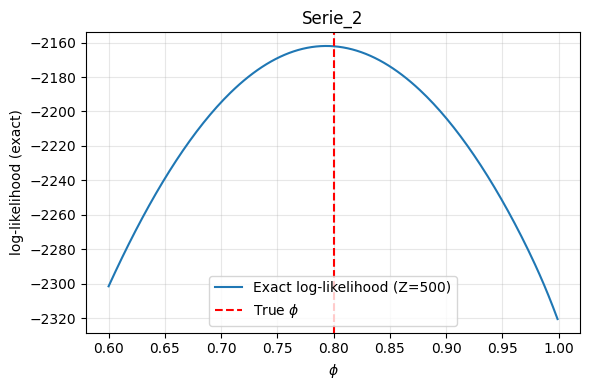

In [4]:
SERIE = "Serie_2"

df = pd.read_csv("../data/stored_result/exact_likelihood_profiles_phi.csv")
g = df[df["series"] == SERIE]

plt.figure(figsize=(6,4))
plt.plot(g["phi"], g["loglik_exact"], label="Exact log-likelihood (Z=500)")
plt.axvline(g["phi_true"].iloc[0], color="red", ls="--", label="True $\phi$")
plt.xlabel(r"$\phi$")
plt.ylabel("log-likelihood (exact)")
plt.title(SERIE)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### $ \nu $ parameter 

In [ ]:
rows = []

nu_grid = np.linspace(1.2, 4.0, 150)

for name, y, X, beta, params in SERIES:
    phi = float(params["phi"])
    c   = float(params["c"])
    nu_true = float(params["nu"])

    f = cf.ExactFilter(y, Z_trunc=500)

    for nu in tqdm(nu_grid, desc=f"Exact nu profile – {name}"):
        ll = f.log_likelihood(
            phi=phi,
            nu=nu,
            c=c,
            X=X,
            coeffs=beta,
            tau=np.ones(len(y))
        )

        rows.append({
            "series": name,
            "nu": nu,
            "loglik_exact": ll,
            "nu_true": nu_true,
            "phi": phi,
            "c": c
        })

# Final DataFrame
df_exact_nu = pd.DataFrame(rows)
csv_path = "../data/stored_result/exact_likelihood_profiles_nu.csv"
df_exact_nu.to_csv(csv_path, index=False)

print(f"Saved exact likelihood profiles over nu to {csv_path}")

Exact ν profile – Serie_1: 100%|██████████| 150/150 [10:36<00:00,  4.24s/it]
/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_6607/1402728884.py:37: RuntimeWarning: divide by zero encountered in matmul
  expo = np.exp(X @ beta)
/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_6607/1402728884.py:37: RuntimeWarning: overflow encountered in matmul
  expo = np.exp(X @ beta)
/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_6607/1402728884.py:37: RuntimeWarning: invalid value encountered in matmul
  expo = np.exp(X @ beta)
Exact ν profile – Serie_3: 100%|██████████| 150/150 [10:37<00:00,  4.25s/it]

Saved exact likelihood profiles over nu to exact_likelihood_profiles_nu.csv


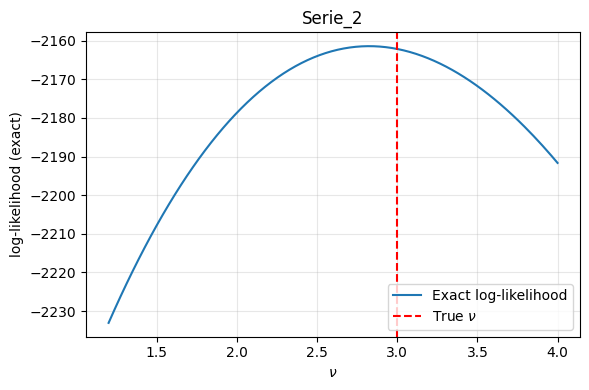

In [5]:
SERIE = "Serie_2"

df = pd.read_csv("../data/stored_result/exact_likelihood_profiles_nu.csv")
g = df[df["series"] == SERIE].sort_values("nu")

plt.figure(figsize=(6,4))
plt.plot(g["nu"], g["loglik_exact"], label="Exact log-likelihood")
plt.axvline(g["nu_true"].iloc[0], color="red", ls="--", label=r"True $\nu$")
plt.xlabel(r"$\nu$")
plt.ylabel("log-likelihood (exact)")
plt.title(SERIE)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Particle Filter 

In [ ]:
phi_grid = np.linspace(0.60, 0.999, 80)
N_LIST = [50, 100, 200, 500, 700]
R = 30  # indenpendent nb of run (MC Variability)

rows = []

for name, y, X, beta, params in SERIES:
    nu = float(params["nu"])
    c  = float(params["c"])
    phi_true = float(params["phi"])        
    for N in tqdm(N_LIST, desc=f"{name} – loop over N"):
        for i, phi in enumerate(tqdm(phi_grid, desc=f"{name} – PF over phi (N={N})", leave=False)):
            for r in range(R):
                ll = pf_loglik_particles_xbeta(
                    y=y, X=X, beta=beta, tau=np.ones(len(y)),
                    nu=nu, phi=phi, c=c,
                    N=N, seed=10_000_000 + 1000*N + 10*i + r
                )

                rows.append({
                    "series": name,
                    "phi": float(phi),
                    "N": int(N),
                    "rep": int(r),
                    "loglik_pf": float(ll),
                    "phi_true": float(phi_true),
                    "nu": float(nu),
                    "c": float(c),
                })

df_pf_phi = pd.DataFrame(rows)

csv_path = "../data/stored_result/pf_likelihood_profiles_phi_80.csv"
df_pf_phi.to_csv(csv_path, index=False)
print(f"Saved PF likelihood profiles to {csv_path} (rows={len(df_pf_phi)})")


Saved PF likelihood profiles to ../data/stored_result/pf_likelihood_profiles_phi_80.csv (rows=36000)


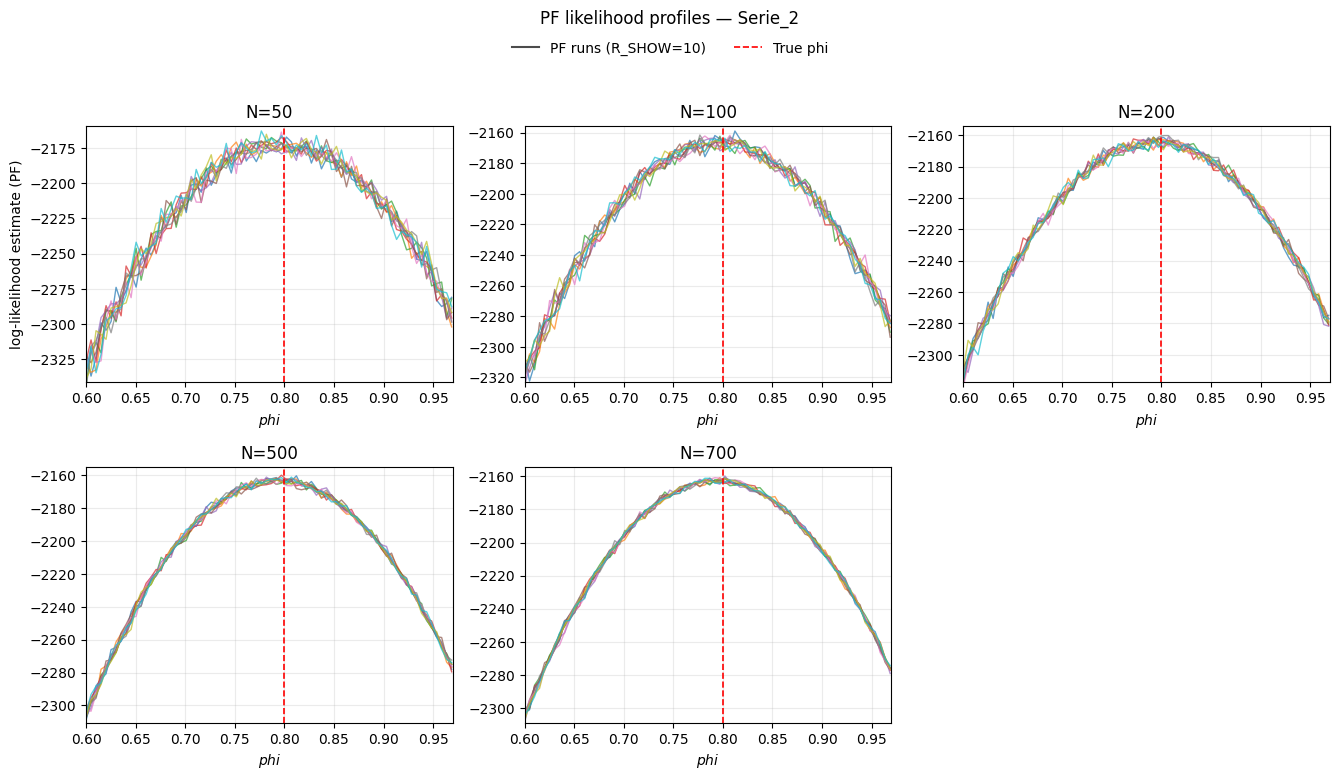

In [6]:
df = pd.read_csv("../data/stored_result/pf_likelihood_profiles_phi_80.csv")
dfS = df[df["series"] == "Serie_2"]

pl.plot_pf_profile_grid(
    dfS=dfS,
    series_name="Serie_2",
    N_list=sorted(dfS["N"].unique()),
    param_col="phi",
    true_col="phi_true",
    x_min=0.60,
    x_max=0.97,
    R_SHOW=10,
    ncols=3
)

/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/utils/plots.py:453: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


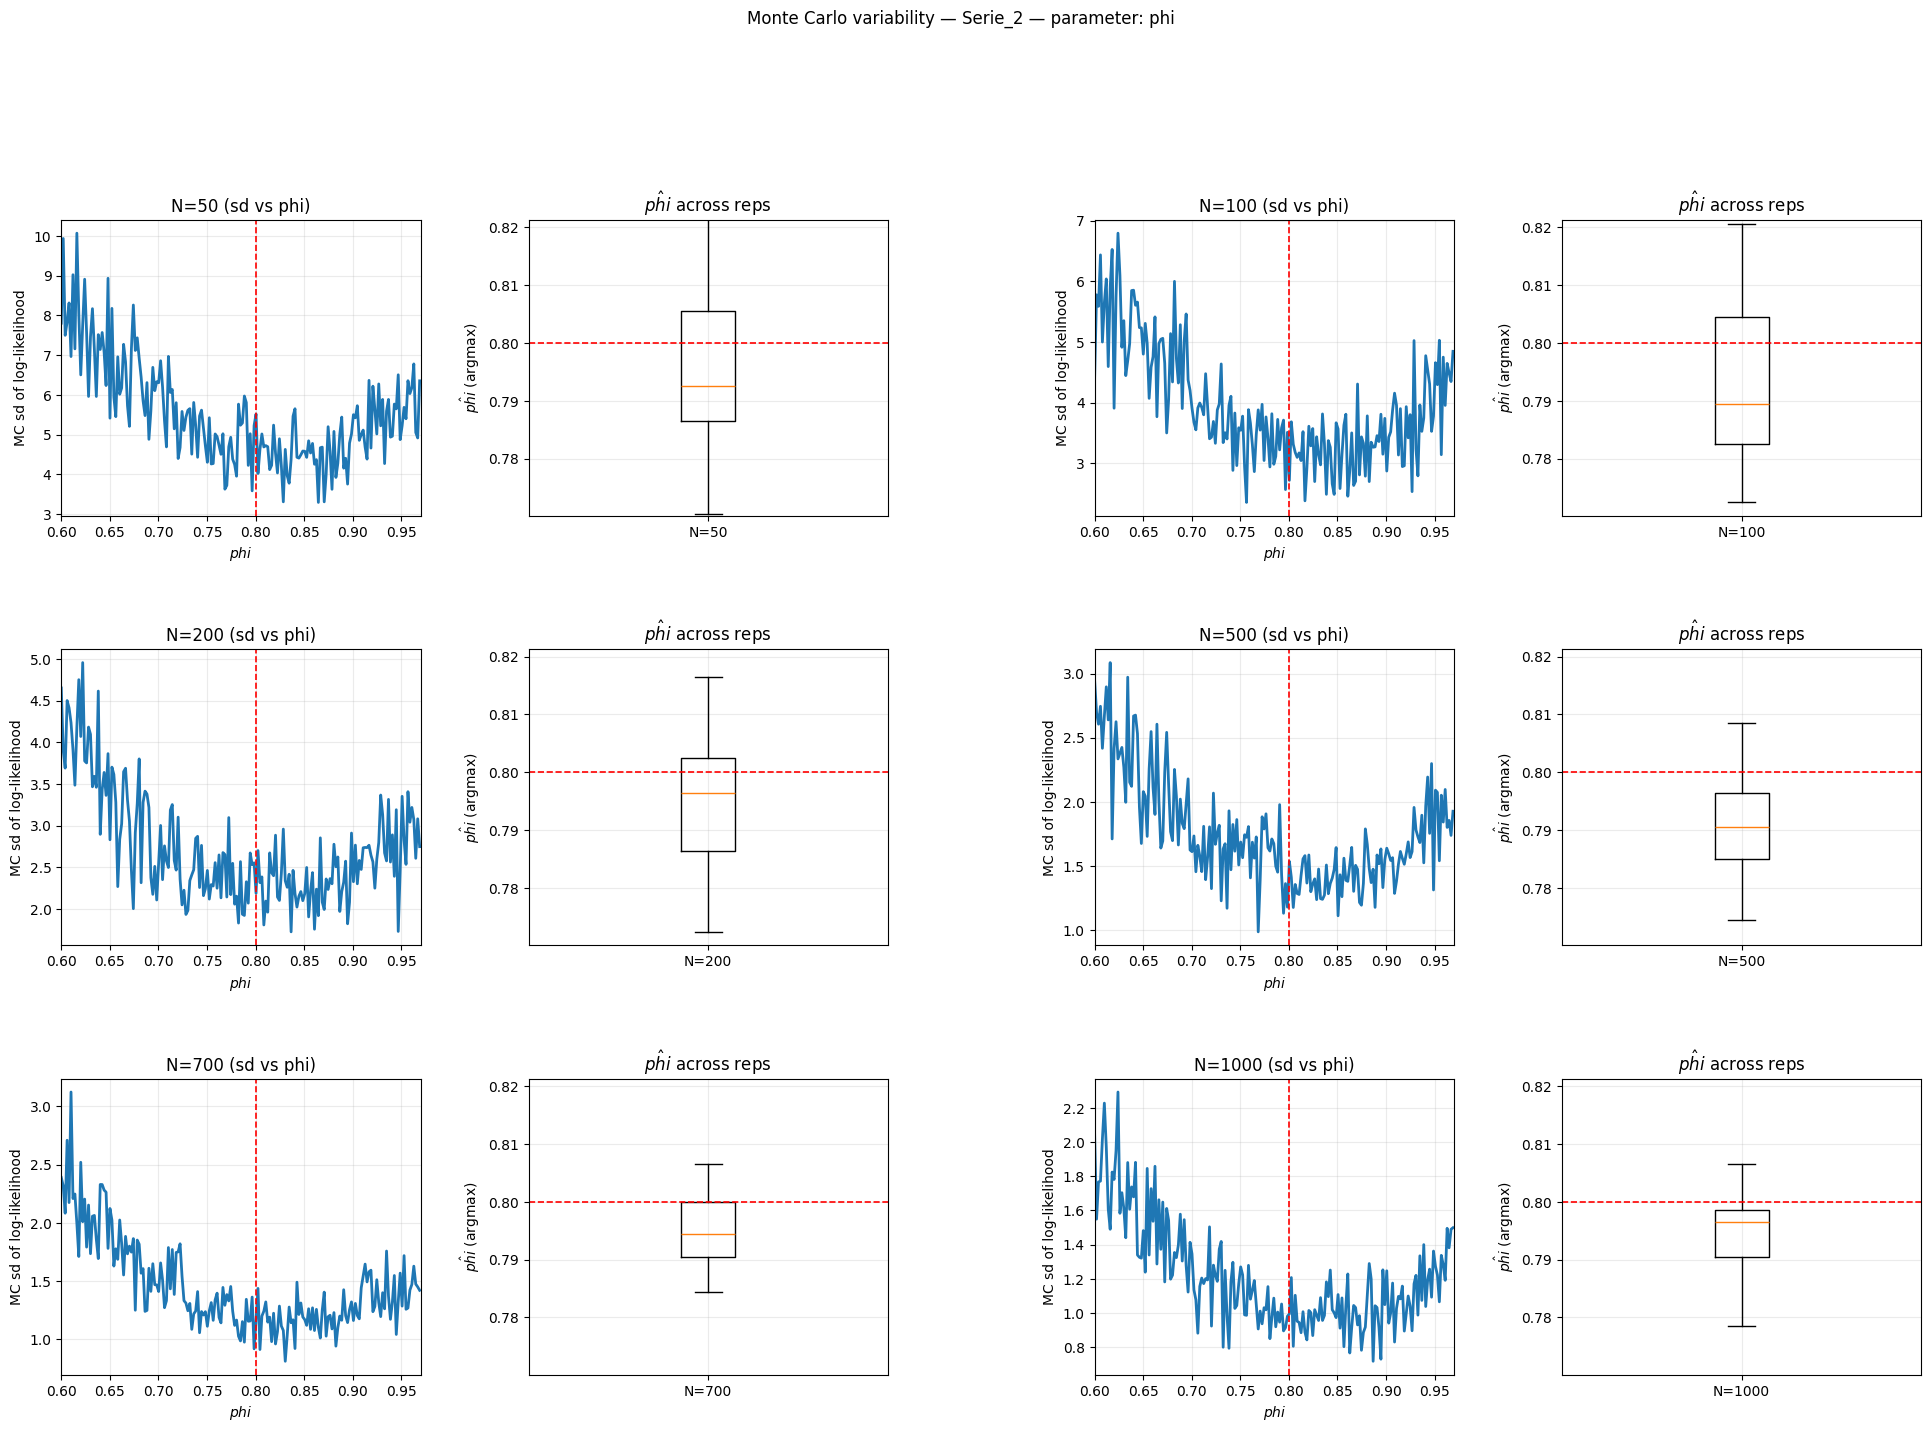

In [7]:
df = pd.read_csv("../data/stored_result/pf_likelihood_profiles_phi.csv")

pl.plot_mc_var_sd_and_hat_grid(
    df=df,
    series="Serie_2",
    param_col="phi",
    true_col="phi_true",
    x_min=0.60,
    x_max=0.97,
    ncols=2,
    figsize_per_cell=(12, 5)
)

### Comparaisons

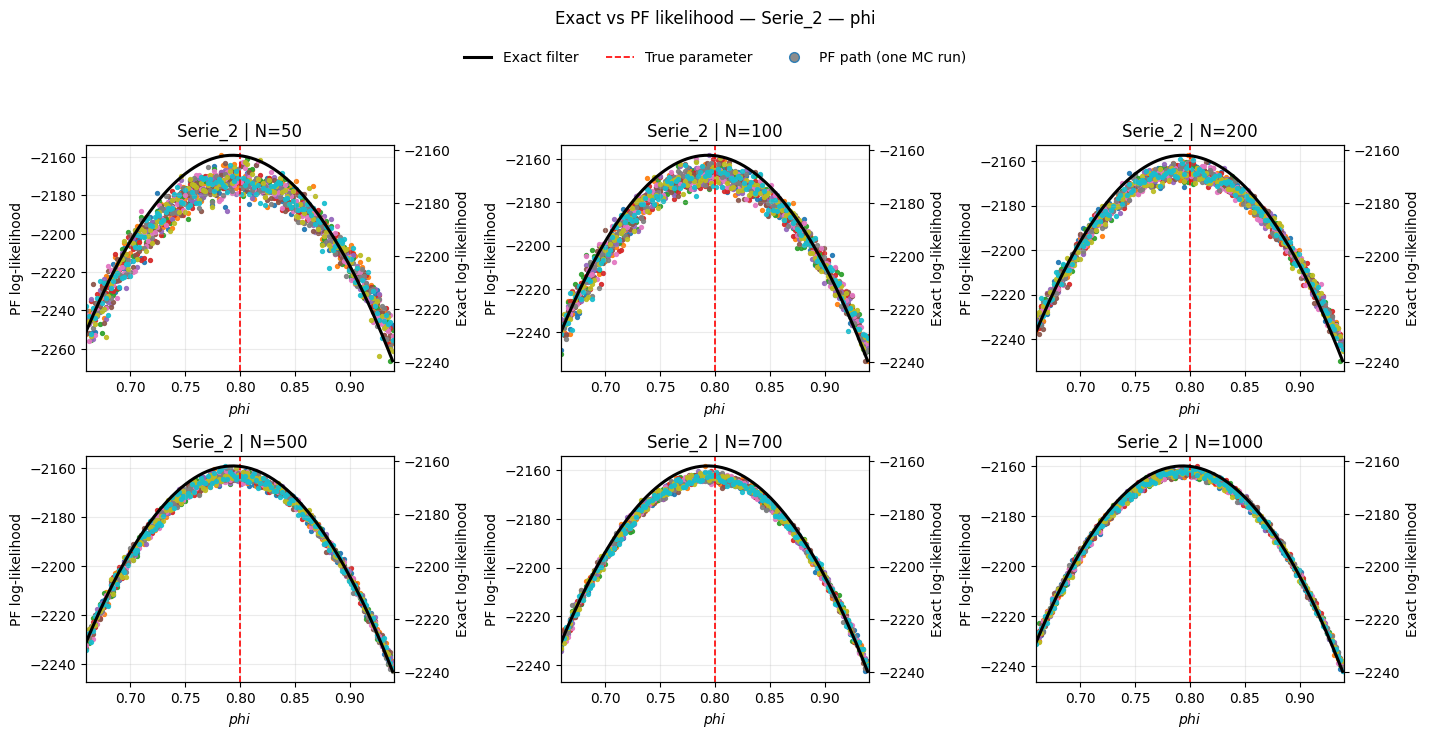

In [8]:
df_pf = pd.read_csv("../data/stored_result/pf_likelihood_profiles_phi.csv")
df_ex = pd.read_csv("../data/stored_result/exact_likelihood_profiles_phi.csv")

pl.plot_exact_vs_pf_cloud_by_rep_grid(
    df_pf=df_pf,
    df_exact=df_ex,
    series="Serie_2",
    param_col="phi",
    true_col="phi_true",
    x_min=0.66,
    x_max=0.94,
    ncols=3,
    pf_alpha=0.9,
    pf_size=8,
    R_SHOW=10,
)

##### Numerical comparison

To quantify the effect of the number of particles \(N\), we compare the particle filter output to the exact reference using numerical error measures computed over a fixed time window:
- root mean squared error (RMSE) between particle filter and exact filtered means;
- mean absolute error (MAE);
- bias and maximum absolute deviation;
- when the true latent state is available, RMSE with respect to the true \(h_t\).

This comparison is repeated for increasing values of \(N\).  
As expected from Monte Carlo theory, the error decreases as the number of particles increases, even when differences are barely visible on the filtered mean trajectories.

Overall, this analysis validates the bootstrap particle filter as a consistent numerical approximation of the exact filter, and illustrates the convergence of the particle approximation as the number of particles grows.

/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/src/creal_filter.py:135: RuntimeWarning: divide by zero encountered in matmul
  lin_pred = X @ beta_coeffs
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/src/creal_filter.py:135: RuntimeWarning: overflow encountered in matmul
  lin_pred = X @ beta_coeffs
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/src/creal_filter.py:135: RuntimeWarning: invalid value encountered in matmul
  lin_pred = X @ beta_coeffs
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/utils/comparaison.py:45: RuntimeWarning: divide by zero encountered in matmul
  expo = tau * np.exp(X @ beta)
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/utils/comparaison.py:45: RuntimeWarning: overflow encountered in matmul
  expo = tau * np.exp(X @ beta)
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/utils/comparaison.py:45: RuntimeWa

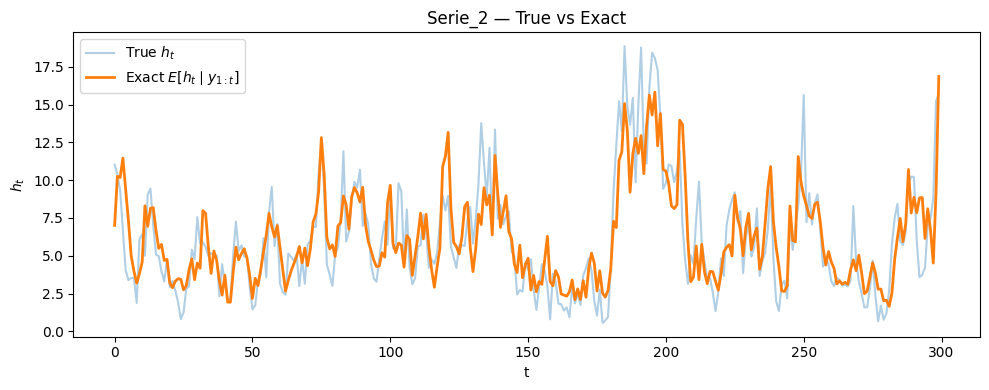

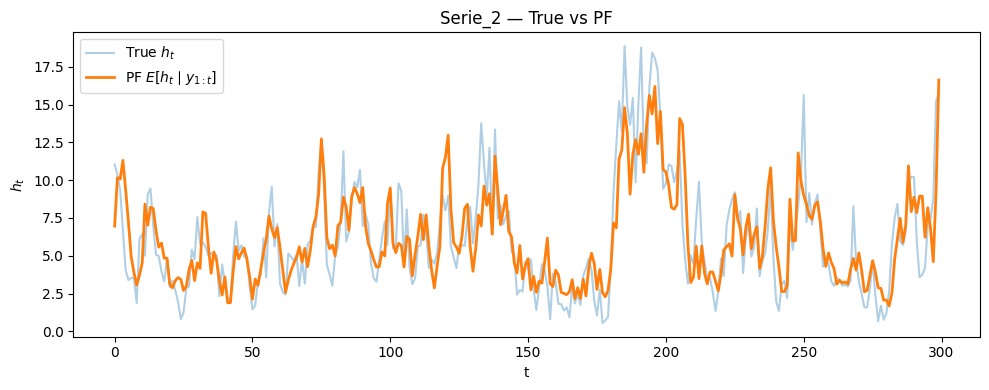

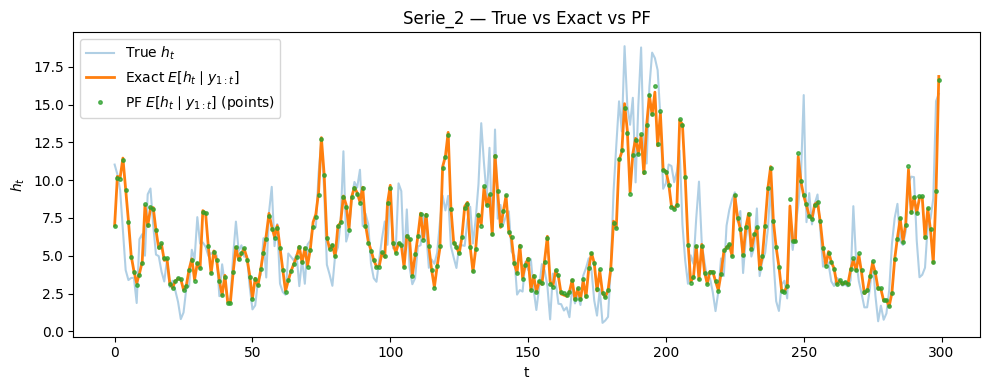

In [4]:
serie = SERIES[1]
y    = serie[1]
X    = serie[2]
beta = serie[3]
p    = serie[4]
tau  = np.ones(len(y))

ll_exact, ll_pf, Eh_exact, Eh_pf = comp.run_exact_pf(
    y=y, X=X, beta=beta, tau=tau,
    nu=p["nu"], phi=p["phi"], c=p["c"],
    Z=500, N=1000, seed=123
)

comp.plot_three(
    Eh_exact=Eh_exact, Eh_pf=Eh_pf,
    h_true=h2, T_max=300, name="Serie_2"
)

In [5]:
N_list = [10, 20, 30, 50, 100, 200, 400, 500, 1000]

rows = []
for N in N_list:
    ll_exact, ll_pf, Eh_exact, Eh_pf = comp.run_exact_pf(
        y=y, X=X, beta=beta, tau=tau,
        nu=p["nu"], phi=p["phi"], c=p["c"],
        Z=500, N=N, seed=123
    )

    m = comp.compare_numeric(Eh_exact, Eh_pf, h_true=h2, T_max=300)
    rows.append(comp.metrics_to_df(m, extra={"N": N, "serie": "Serie_2"}))

df = pd.concat(rows, ignore_index=True)
df.to_csv("../data/stored_result/pf_vs_exact_metrics_serie2.csv", index=False)

display(df) 

/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/src/creal_filter.py:135: RuntimeWarning: divide by zero encountered in matmul
  lin_pred = X @ beta_coeffs
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/src/creal_filter.py:135: RuntimeWarning: overflow encountered in matmul
  lin_pred = X @ beta_coeffs
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/src/creal_filter.py:135: RuntimeWarning: invalid value encountered in matmul
  lin_pred = X @ beta_coeffs
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/utils/comparaison.py:45: RuntimeWarning: divide by zero encountered in matmul
  expo = tau * np.exp(X @ beta)
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/utils/comparaison.py:45: RuntimeWarning: overflow encountered in matmul
  expo = tau * np.exp(X @ beta)
/Users/brianramesh/Documents/HMM_project/Non-Gaussian-State-Space-Models/utils/comparaison.py:45: RuntimeWa

,T_used,RMSE_pf_vs_exact,MAE_pf_vs_exact,Bias_pf_vs_exact,MaxAbs_pf_vs_exact,RMSE_exact_vs_true,RMSE_pf_vs_true,N,serie
0,300,1.218577,0.843685,-0.032086,5.800114,2.039289,2.286504,10,Serie_2
1,300,0.714820,0.536434,-0.151679,2.669177,2.039289,2.124402,20,Serie_2
2,300,0.634118,0.426238,-0.100197,4.273066,2.039289,2.119715,30,Serie_2
3,300,0.576288,0.354409,-0.068511,4.278312,2.039289,2.074215,50,Serie_2
4,300,0.259388,0.193699,0.019332,1.180903,2.039289,2.058599,100,Serie_2
5,300,0.210613,0.145472,0.006343,0.962932,2.039289,2.039144,200,Serie_2
6,300,0.152824,0.111662,0.006960,0.706527,2.039289,2.030934,400,Serie_2
7,300,0.152987,0.095738,-0.005100,1.350923,2.039289,2.057505,500,Serie_2
8,300,0.124332,0.067935,-0.008723,1.451200,2.039289,2.048671,1000,Serie_2
